### Evaluation of Manipulation experiments

In [409]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt

%matplotlib notebook
from IPython.display import display

In [410]:
import os
import numpy as np
import signal_logger
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True
import rospkg

from utilities import *

rospack = rospkg.RosPack()
ROOT_DIR = os.path.join(rospack.get_path("mppi_manipulation_royalpanda"),
                        "logs")
LOG_PREFIX = "mppi_manipulation"
LOG_FILE = os.path.join(ROOT_DIR, "filter.silo")
LOG_FILES = get_files(ROOT_DIR, LOG_PREFIX)
REQUIRED_FIELDS = [
    "log/sim_time", "log/stage_cost", "log/torque_command",
    "log/cartesian_limits_violation", "log/joint_limits_violation",
    "log/solver/rollouts/min_cost", "log/velocity_command",
    "log/velocity_filtered", "log/velocity_measured", "log/position_desired", "log/position_measured",
    "log/tank_state", "log/solver/delay_steps", "log/power_from_error", 
    "log/power_from_interaction", "log/total_power_exchange", "log/external_torque", "log/power_channels"
]
LOG_FILES_PRINT = '\n'.join(LOG_FILES)
print(f"""
>> Root dir: 
{ROOT_DIR}
>> Prefix: 
{LOG_PREFIX}
>> Log files: 
{LOG_FILES_PRINT}
""")


>> Root dir: 
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs
>> Prefix: 
mppi_manipulation
>> Log files: 
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/mppi_manipulation.silo



### Fields available in log fie

In [411]:
silo = signal_logger.Silo(LOG_FILES[0])
print_keys(silo)

Removing prefix /log/ which is common to all signals
Logger contains the following keys (123):
[log/power_from_error]
[log/position_desired_0]
[log/position_desired_1]
[log/position_desired_2]
[log/position_desired_3]
[log/position_desired_4]
[log/position_desired_5]
[log/position_desired_6]
[log/position_desired_7]
[log/position_desired_8]
[log/position_desired_9]
[log/power_channels_0]
[log/power_channels_1]
[log/power_channels_2]
[log/power_channels_3]
[log/power_channels_4]
[log/power_channels_5]
[log/power_channels_6]
[log/power_channels_7]
[log/power_channels_8]
[log/power_channels_9]
[log/position_measured_0]
[log/position_measured_1]
[log/position_measured_2]
[log/position_measured_3]
[log/position_measured_4]
[log/position_measured_5]
[log/position_measured_6]
[log/position_measured_7]
[log/position_measured_8]
[log/position_measured_9]
[log/cartesian_limits_violation_0]
[log/cartesian_limits_violation_1]
[log/velocity_measured_0]
[log/velocity_measured_1]
[log/velocity_measur

### Collect and process
Each experiment contributes to a single dictionary where all the information is stored

In [412]:
final_time = 65.0
data = {}
data['experiment_name'] = []
data['joint_limits_violation_se'] = []
data['cartesian_limits_violation_se'] = []

for experiment_idx, file in enumerate(LOG_FILES):
    experiment_name = file.split('/')[-1].replace('.silo', '')
    silo = signal_logger.Silo(file)
    silo_dict = to_dictionary(silo, REQUIRED_FIELDS)

    for key, value in silo_dict.items():
        if experiment_idx == 0:
            data[key] = [value]
        else:
            data[key].append(value)
    
    time = silo_dict['sim_time']
    joint_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['joint_limits_violation'])
    carts_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['cartesian_limits_violation'])
    
    data['experiment_name'].append(experiment_name)
    data['joint_limits_violation_se'].append(joint_violation_se)
    data['cartesian_limits_violation_se'].append(carts_violation_se)

Removing prefix /log/ which is common to all signals


### Select experiment to plot

In [413]:
exp_idx = 0
exp_name_wg = widgets.Dropdown(options=data['experiment_name'])
def exp_name_handler(exp_name):
    exp_idx = data['experiment_name'].index(exp_name)
exp_name_wg.observe(exp_name_handler, names='value')

### Delay steps
The solver keeps track of delay in optimizing the plan to adapt which portion of input is optimized in the future.

<IPython.core.display.Javascript object>


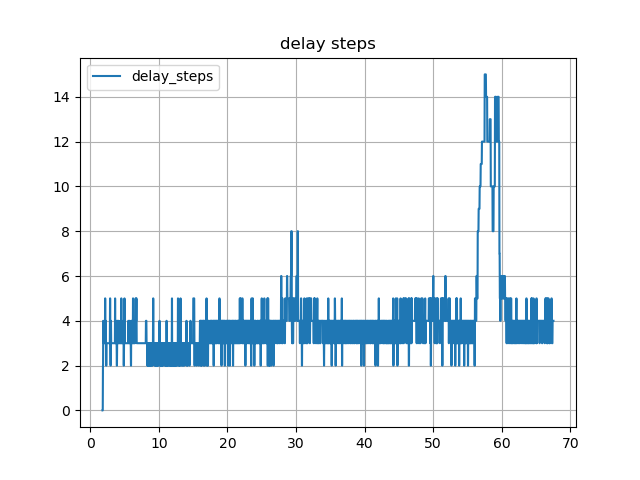

Text(0.5, 1.0, 'delay steps')

In [414]:
ax = scalar_plot(data['sim_time'][exp_idx], data['delay_steps'][exp_idx], prefix="delay_steps")
ax.set_title("delay steps")

### Energy tank

<IPython.core.display.Javascript object>


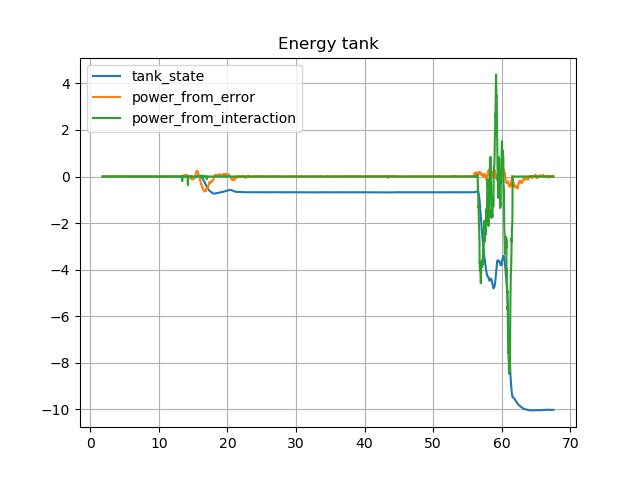

<IPython.core.display.Javascript object>


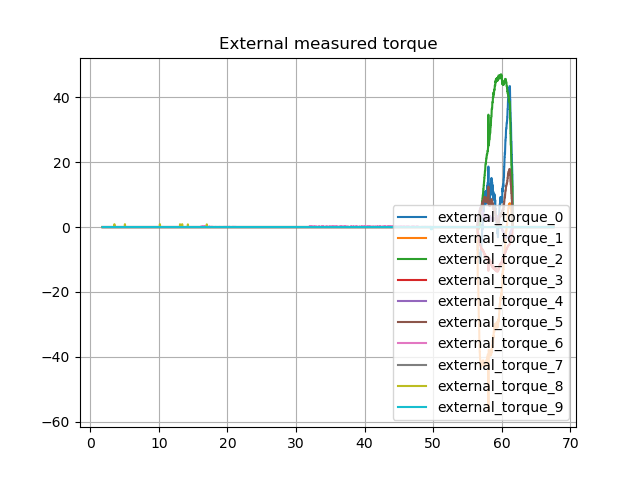

<IPython.core.display.Javascript object>


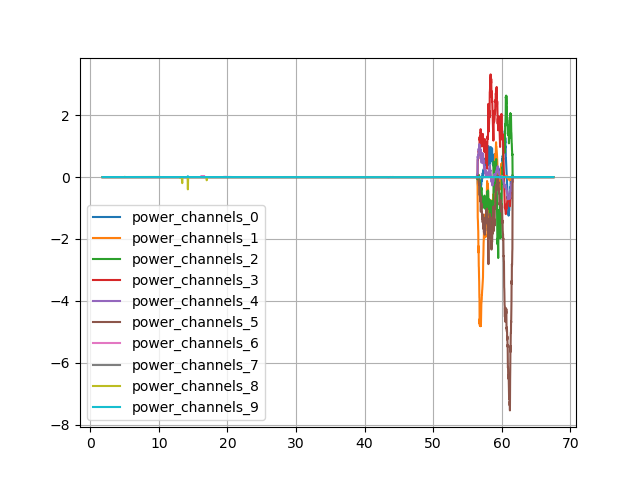

In [415]:
ax = scalar_plot(data['sim_time'][exp_idx], data['tank_state'][exp_idx], prefix="tank_state")
ax.plot(data['sim_time'][exp_idx], data['power_from_error'][exp_idx], label="power_from_error")
ax.plot(data['sim_time'][exp_idx], data['power_from_interaction'][exp_idx], label="power_from_interaction")
ax.set_title("Energy tank")
ax.legend()

ax2 = matrix_plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx], prefix="external_torque")
ax2.set_title("External measured torque")
ax2.legend()

matrix_plot(data['sim_time'][exp_idx], data['power_channels'][exp_idx], prefix="power_channels")

### Stage cost

<IPython.core.display.Javascript object>


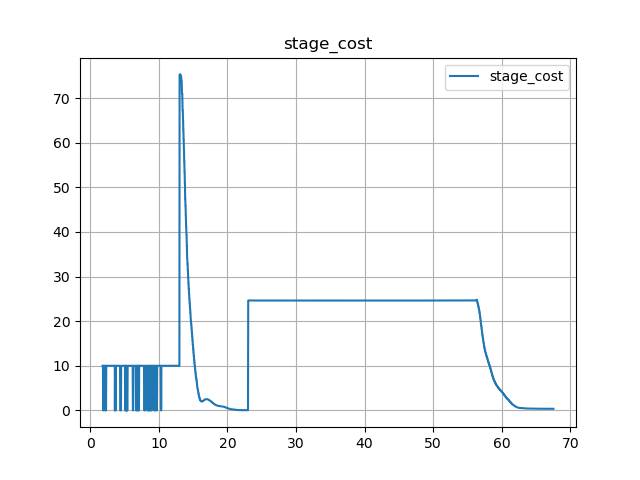

Text(0.5, 1.0, 'stage_cost')

In [416]:
ax = scalar_plot(data['sim_time'][exp_idx], data['stage_cost'][exp_idx], prefix="stage_cost")
ax.set_title("stage_cost")

### Min cost

<IPython.core.display.Javascript object>


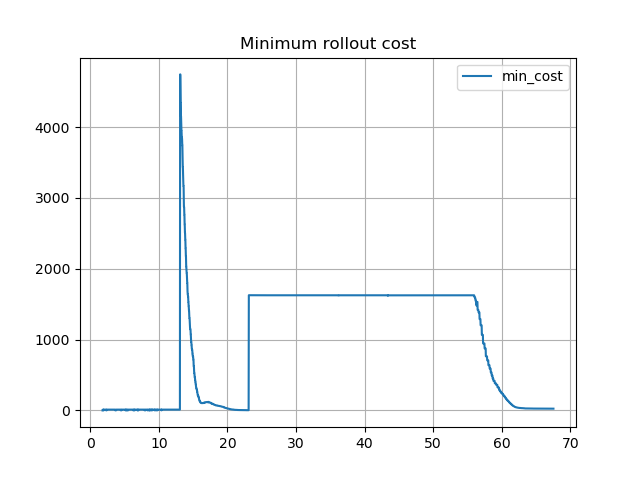

Text(0.5, 1.0, 'Minimum rollout cost')

In [417]:
ax = scalar_plot(data['sim_time'][exp_idx], data['min_cost'][exp_idx], prefix="min_cost")
ax.set_title("Minimum rollout cost")

### Position desired

<IPython.core.display.Javascript object>


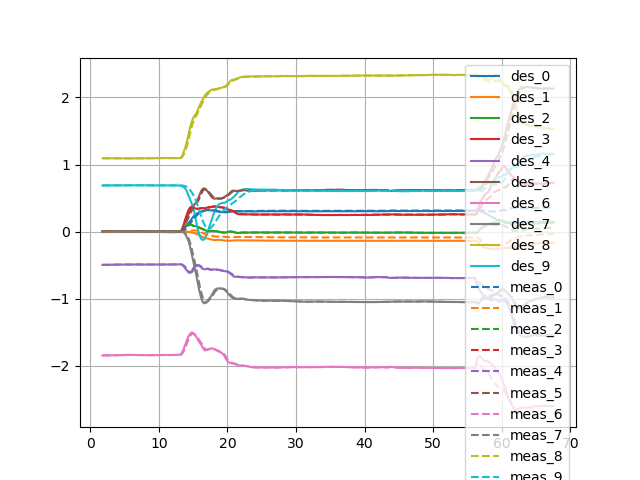

In [418]:
ax = matrix_plot(data['sim_time'][exp_idx], data['position_desired'][exp_idx], prefix="des")
ax = matrix_plot(data['sim_time'][exp_idx], data['position_measured'][exp_idx], prefix="meas", 
                 linestyle="--", axis=ax)

### Velocity measured

<IPython.core.display.Javascript object>


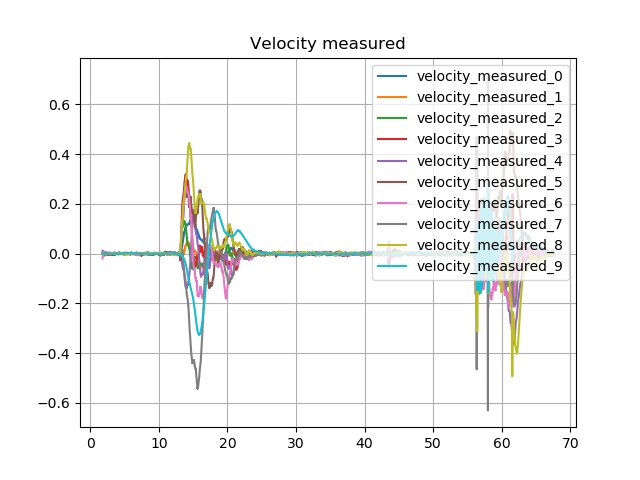

Text(0.5, 1.0, 'Velocity measured')

In [419]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx], prefix="velocity_measured")
ax.set_title("Velocity measured")

### Velocity filtered

<IPython.core.display.Javascript object>


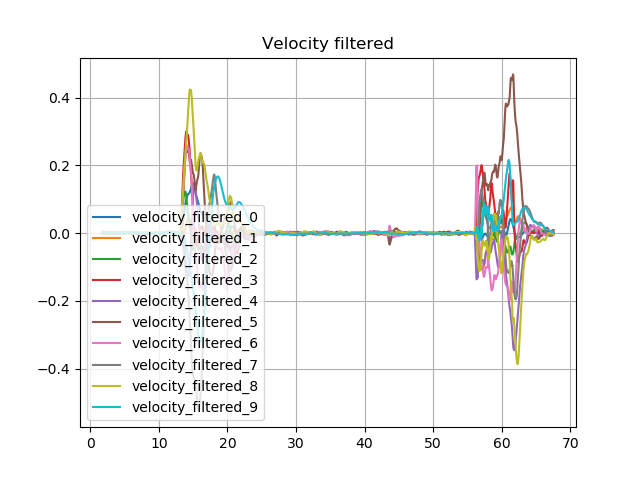

<IPython.core.display.Javascript object>


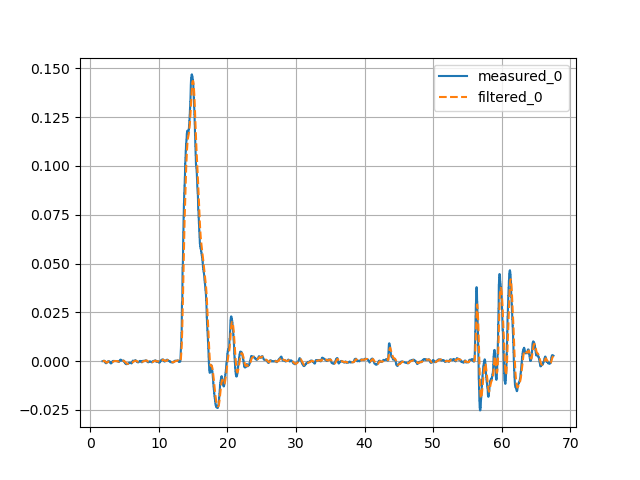

In [420]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx], prefix="velocity_filtered")
ax.set_title("Velocity filtered")

# Compare filtered agains measured
uidx = 0
fig2, ax2 = plt.subplots()
ax2.plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx][:, uidx], label=f"measured_{uidx}")
ax2.plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx][:, uidx], '--', label=f"filtered_{uidx}")
ax2.legend()


### Velocity command

<IPython.core.display.Javascript object>


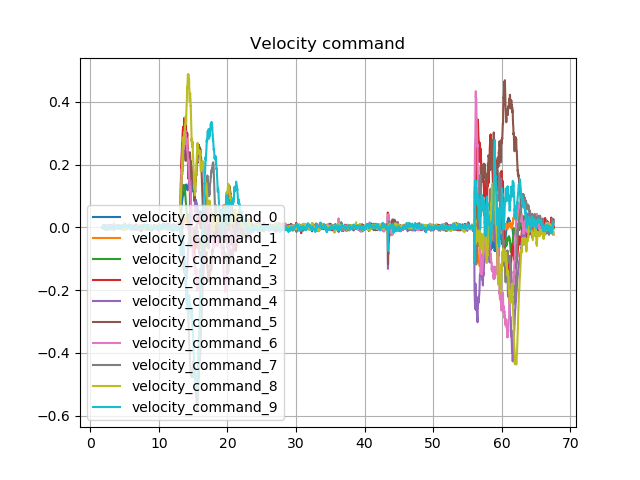

Text(0.5, 1.0, 'Velocity command')

In [421]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_command'][exp_idx], prefix="velocity_command")
ax.set_title("Velocity command")

### Torque command

<IPython.core.display.Javascript object>


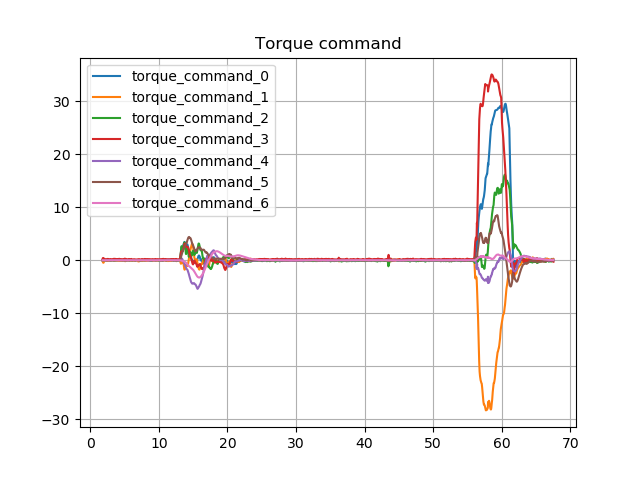

Text(0.5, 1.0, 'Torque command')

In [422]:
ax = matrix_plot(data['sim_time'][exp_idx], data['torque_command'][exp_idx], prefix="torque_command")
ax.set_title("Torque command")

### Joint limits violation

<IPython.core.display.Javascript object>


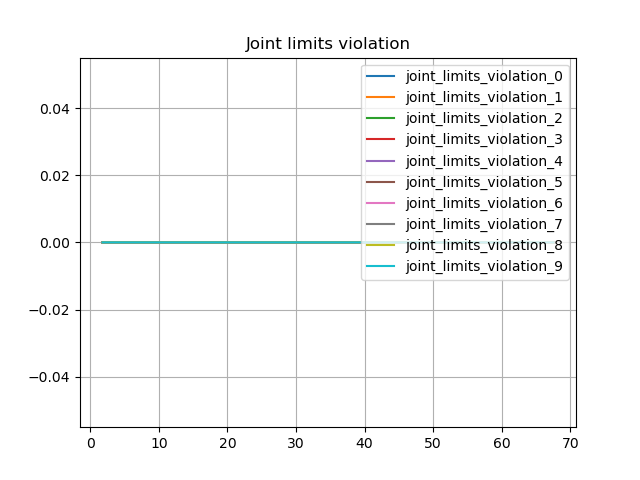

Text(0.5, 1.0, 'Joint limits violation')

In [423]:
ax = matrix_plot(data['sim_time'][exp_idx], data['joint_limits_violation'][exp_idx], 
                 prefix="joint_limits_violation")
ax.set_title("Joint limits violation")

### Cartesian limits violation

<IPython.core.display.Javascript object>


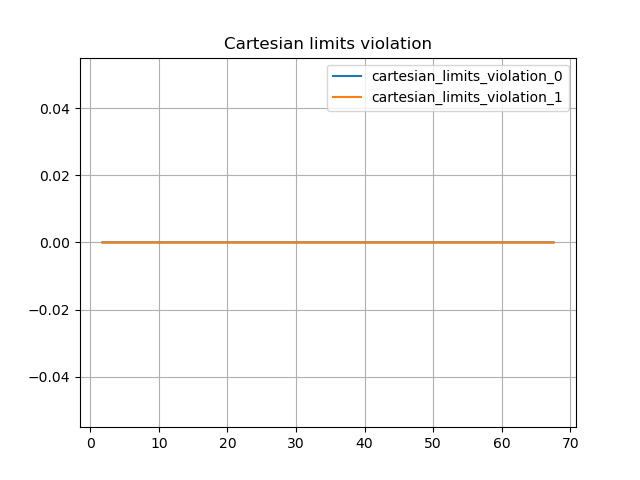

Text(0.5, 1.0, 'Cartesian limits violation')

In [424]:
ax = matrix_plot(data['sim_time'][exp_idx], data['cartesian_limits_violation'][exp_idx], 
            prefix="cartesian_limits_violation")
ax.set_title("Cartesian limits violation")

### Squared violation

<IPython.core.display.Javascript object>


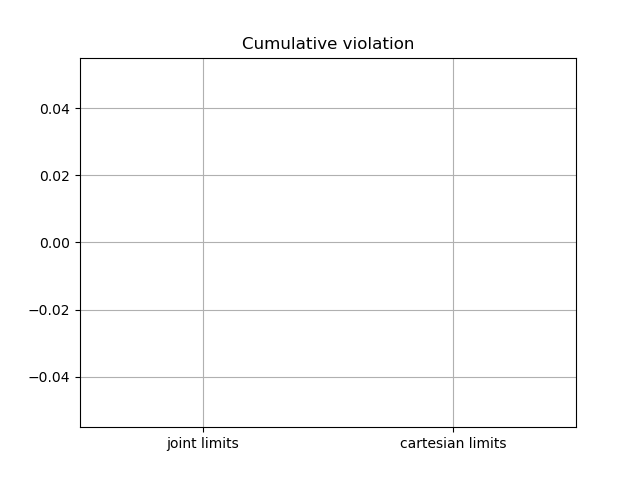

Text(0.5, 1.0, 'Cumulative violation')

In [425]:
fig, ax = plt.subplots()
ax.bar(["joint limits", "cartesian limits"],
       [data['joint_limits_violation_se'][exp_idx], data['cartesian_limits_violation_se'][exp_idx]])
ax.set_title("Cumulative violation")